In [63]:
import os
import re
import shutil
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import optimizers, datasets
from keras import Model
from keras import applications
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.initializers import Constant
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.advanced_activations import PReLU
from keras.initializers import he_normal, he_uniform

In [23]:
# seems to reduce the chance of gpu errors

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

In [24]:
batch_size = 64

In [16]:
datagen = ImageDataGenerator(rescale=1./255, 
                             validation_split=0.2)

if os.path.isdir('preview'):
    shutil.rmtree('preview')
os.makedirs('preview')
img = load_img('data/train/cat/204.png')
x = img_to_array(img)          # array with shape (3, 32, 32)
x = x.reshape((1,) + x.shape)  # array with shape (1, 3, 32, 32)

i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='png'):
    i += 1
    if i > 20:
        break

In [25]:
datagen_aug = ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2, 
                                 horizontal_flip=True,
                                 width_shift_range=3,
                                 height_shift_range=3)

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)



train_generator = datagen_aug.flow_from_directory('data/train',
                                                    target_size=(32, 32),
                                                    batch_size=batch_size,
                                                    seed=0,
                                                    subset='training')

validation_generator = datagen.flow_from_directory('data/train',
                                                    target_size=(32, 32),
                                                    batch_size=batch_size,
                                                    seed=0,
                                                    subset='validation')

Found 40000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [64]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(4e-4), kernel_initializer=he_normal(), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(4e-4), kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(4e-4), kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(4e-4), kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(4e-4), kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(4e-4), kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(4e-4), kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(4e-4), kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(4e-4), kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(4e-4), kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(512, kernel_regularizer=l2(4e-4), kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, kernel_regularizer=l2(4e-4)))
model.add(BatchNormalization())
model.add(Activation('softmax'))

opt = optimizers.Adam(lr = 0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [27]:
history = model.fit_generator(train_generator,
                              epochs=400,
                              workers=2, # weirdly enough 3 works best (training on 6c/12t)
                              validation_data=validation_generator,
                              steps_per_epoch=40000 // batch_size,
                              validation_steps=10000 // batch_size)

Epoch 1/400
625/625 [==============================] - 39s 63ms/step - loss: 2.8599 - accuracy: 0.2077 - val_loss: 3.3145 - val_accuracy: 0.1074
Epoch 2/400
625/625 [==============================] - 36s 58ms/step - loss: 2.5157 - accuracy: 0.3259 - val_loss: 3.0965 - val_accuracy: 0.1631
Epoch 3/400
625/625 [==============================] - 36s 58ms/step - loss: 2.3024 - accuracy: 0.4202 - val_loss: 2.6060 - val_accuracy: 0.2788
Epoch 4/400
625/625 [==============================] - 37s 59ms/step - loss: 2.1212 - accuracy: 0.4916 - val_loss: 2.7470 - val_accuracy: 0.3182
Epoch 5/400
625/625 [==============================] - 36s 58ms/step - loss: 1.9784 - accuracy: 0.5367 - val_loss: 2.4563 - val_accuracy: 0.4357
Epoch 6/400
625/625 [==============================] - 36s 58ms/step - loss: 1.8508 - accuracy: 0.5791 - val_loss: 1.8363 - val_accuracy: 0.5319
Epoch 7/400
625/625 [==============================] - 36s 58ms/step - loss: 1.7467 - accuracy: 0.6045 - val_loss: 1.8023 - val_ac

In [3]:
# save_bottlebeck_features
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

model = applications.densenet.DenseNet201(input_shape=(32,32,3), include_top=False, weights='imagenet')

t_generator = datagen.flow_from_directory('data/train',
                                           subset='training',
                                           seed=0,
                                           shuffle=False,
                                           class_mode=None,
                                           target_size=(32, 32),
                                           batch_size=40000)
with tf.device('/cpu:0'):
    bottleneck_features_train = model.predict_generator(t_generator, 1)
np.save('bottleneck_features_train.npy', bottleneck_features_train)

v_generator = datagen.flow_from_directory('data/train',
                                           subset='validation',
                                           seed=0,
                                           shuffle=False,
                                           class_mode=None,
                                           target_size=(32, 32),
                                           batch_size=10000)
with tf.device('/cpu:0'):
    bottleneck_features_validation = model.predict_generator(v_generator, 1)
np.save('bottleneck_features_validation.npy', bottleneck_features_validation)

Found 40000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [ ]:
# train_top_model
train_data = np.load('bottleneck_features_train.npy')
l = []
for i in range(10):
    l = l + [i] * 4000
train_labels = to_categorical(np.array(l), num_classes=10)
    
validation_data = np.load('bottleneck_features_validation.npy')
l = []
for i in range(10):
    l = l + [i] * 1000
validation_labels = to_categorical(np.array(l), num_classes=10)

model = Sequential()
model.add(Flatten(input_shape=(train_data.shape[1:])))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_data, 
                    train_labels,
                    epochs=16,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels))

In [11]:
model.save_weights('top_layer_model.h5')

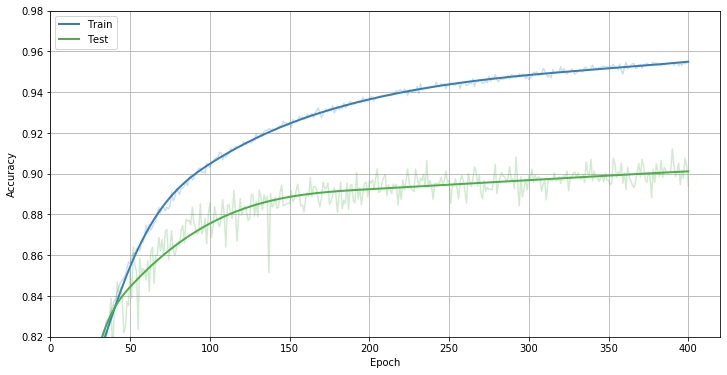

In [67]:
from scipy.interpolate import UnivariateSpline

f = plt.figure(figsize=(12,6))

x = range(1, 401)
y1 = history.history['accuracy']
y2 = history.history['val_accuracy']

xs = np.linspace(1, 400, 1000)
y1s = UnivariateSpline(x, y1, s=0.01)(xs)
y2s = UnivariateSpline(x, y2, s=0.06)(xs)

plt.plot(xs, y1s, color='#377eb8', linewidth=2.0)
plt.plot(xs, y2s, color='#4daf4a', linewidth=2.0)
plt.plot(x, y1, color='#377eb840')
plt.plot(x, y2, color='#4daf4a40')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim(0.82, 0.98)
plt.xlim(0)
plt.grid()
plt.show()


#f.savefig('dropout_before_dense.svg', bbox_inches='tight')

In [95]:
model.save_weights('90.71_4h_batch64_epoch200_[cnv_32x2_64x2_128x3_256x3]_dns[512]_(l2_4e-4).h5')

In [31]:
model.load_weights('89.96_2h_batch64_epoch200_[cnv_32x2_64x2_128x2_256x2]_dns[512]_(progressive_dropout_except_before_pooling).h5')

In [97]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('data/test',
                                                   target_size=(32, 32),
                                                   batch_size=128,
                                                   shuffle=False)

Found 300000 images belonging to 1 classes.


In [98]:
pred=model.predict_generator(test_generator, steps=len(test_generator), verbose=1)

4688/4688 [==============================] - 319s 68ms/step


In [103]:
indices = np.argmax(pred, axis=1)
ids = [int(re.sub('\D+', '', name)) for name in test_generator.filenames]
flipped = {v:k for k,v in validation_generator.class_indices.items()}
labels = [flipped[i] for i in indices]
submission = pd.DataFrame({'id':ids, 'label':labels}).sort_values(['id']).reset_index(drop=True)

In [106]:
submission.to_csv('submission.csv', index=False)

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_layer_names=False, show_shapes=True)

#### 2x32_2x64_2x128_2x256_512
31s per epoch
* 88% - 42 min
* 89% - 55 min

#### 2x32_2x64_3x128_3x256_512
36s per epoch
* 88% - 51 min
* 89% - 1.2 h
* 90% - 1.8 h

#### l2 regularization 1e-4 --> 4e-4
36s per epoch
* 88% - 50 min
* 89% -  1  h
* 90% - 1.7 h
  
![](90.71_4h_batch64_epoch400_2x32_2x64_3x128_3x256_512_(l2_4e-4).svg)

#### ELU without BN
22s per epoch  
worse performance, barely reaching 88% in 1.3h

#### PReLU with alpha 0.25 and bigger batches (128)
36s per epoch (would be higher if same batch size would be used)  
similar to last best model but converges slower  
![](90.54_3h_batch128_epoch300_2x32_2x64_3x128_3x256_512_PReLU.svg)

#### Bigger batches (128)
29s per epoch  
![](bigbatch.svg)  
So PReLU may work after all, but will be used only at the end (after tuning) bcs it makes training too long

#### Dropout before dense
36s per epoch  
![](dropout_before_dense.svg)  
It seems this model would benefit from more learning time.  
It is used as a base further on.

#### He_normal initialization
